In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft
import matplotlib.colors as colors
import gc
import os
import xarray as xr

nxw = 1280
nyw = 1
nnx = 2*nxw+1
nny = 2*nyw+1
nx = nxw
ny  = int(nyw/3)*2
print("ny",ny)

global_nz = 64
nprocz_mpi = 16
nprocz = 1
nzero = nny - (ny+ny+1)  

nz = int(global_nz/nprocz_mpi)
print(nz)

Veb = 0  # EB drift

size = 8 + ( 16*(2*nx+1)*(ny+1)*(2*nz) )* 4 # time+omg+cpr+phi+psi
# size_timestep = size + 4 *2                 # 1タイムステップあたりのサイズ= size+header+footer
# size = 8 + ( 16*(2*nx+1)*(ny+1)*(2*nz) )* 2 # time+omg+cpr
size_timestep = size + 4*2                 # 1タイムステップあたりのサイズ= size+header+footer
file_size = os.path.getsize('./Fld/rmhdfs_r0.1.slab_linear.run07D4_j-phi.g0000.mag.001') #ファイルサイズ

nt = int(file_size/size_timestep)
print(nt)

ny 0
4
1801


In [2]:
# 座標データ結合
grid = np.zeros( ( 2*nz*nprocz_mpi , nnx, 6 ), dtype="float32")
for inp in range(0,nprocz_mpi):
    data_npz = np.loadtxt("./Grid/rmhdfs_r0.1.slab_linear.run07D4_j-phi.g{:0=4}.grid.001".format(inp)).reshape(2*nz, 2*nx+1, 8) # r, theta, b0, h1, h2
    grid[ inp*2*nz: (inp+1)*2*nz , : , 0] = data_npz[:,:,0]
    grid[ inp*2*nz: (inp+1)*2*nz , : , 1] = data_npz[:,:,1]
    grid[ inp*2*nz: (inp+1)*2*nz , : , 2] = data_npz[:,:,6]
    grid[ inp*2*nz: (inp+1)*2*nz , : , 3] = data_npz[:,:,7]
    grid[ inp*2*nz: (inp+1)*2*nz , : , 4] = data_npz[:,:,2]
    grid[ inp*2*nz: (inp+1)*2*nz , : , 5] = data_npz[:,:,5]   # h3

In [3]:
kymin  = 598.9260225878468 *np.sin(np.pi/9.0)/ 2.0
ky = kymin * np.arange(ny+1)
wky = ky
dy = 2.0*np.pi/kymin / nny
wy1 = np.arange(0, np.pi/kymin, dy, dtype="float64")
wy2 = np.arange(-np.pi/kymin, -dy,  dy, dtype="float64")
y = np.concatenate( (wy2,wy1) ) 
wky_c = [0]*(ny)
for i in range(0,ny,1):
    wky_c[i] = -wky[ny-i]

nzero = nny - (ny+ny+1)                               ## 空要素数
wrk1 = np.zeros((nzero,nnx), dtype="complex128")    ## for fourier, 複素数空配列
wrkky1  = np.zeros((nzero), dtype="float64")
wrkky2 = np.concatenate((wky,wrkky1,wky_c), axis=0)    
del wrkky1, wky_c, wy1, wy2, ky
gc.collect()    


dy = 2.0*np.pi/ kymin / nny
wy1 = np.arange(0, np.pi/kymin, dy, dtype="float64")
wy2 = np.arange(-np.pi/kymin, -dy,  dy, dtype="float64")
y = np.concatenate( (wy2,wy1) ) 

ky_exp = np.zeros( (nny), dtype="float64" )
ky_main_part = wky[1:]  # ky=0を除いた
ky_exp[1:ny+1] = ky_main_part[:]
ky_exp[ny+nzero+1:] = -ky_main_part[::-1]

ky_exp[0:ny+1] = wky[:]
ky_exp[ny+nzero+1:] = -wky[-1:-ny-1:-1]

0

In [5]:
####### バイナリを読む->t=itのデータを得る #######

def read_binary(ip,it):
    f = open("./Fld/rmhdfs_r0.1.slab_linear.run07D4_j-phi.g{:0=4}.mag.001".format(ip))
    f.seek(it*(size+4*2))
    header = np.fromfile(f, dtype= np.int32, count=1 )
    t = np.fromfile(f, dtype= np.float64, count=1)
    womg = np.fromfile(f, dtype = np.complex128, count= (2*nx+1)*(ny+1)*(2*nz) ).reshape(2*nz, ny+1, 2*nx+1)
    wcpr = np.fromfile(f, dtype = np.complex128, count= (2*nx+1)*(ny+1)*(2*nz) ).reshape(2*nz, ny+1, 2*nx+1)
    wphi = np.fromfile(f, dtype = np.complex128, count= (2*nx+1)*(ny+1)*(2*nz) ).reshape(2*nz, ny+1, 2*nx+1)
    wpsi = np.fromfile(f, dtype = np.complex128, count= (2*nx+1)*(ny+1)*(2*nz) ).reshape(2*nz, ny+1, 2*nx+1)
    footer = np.fromfile(f, dtype= np.int32, count=1 )
    # footer = np.fromfile(f, dtype= np.int32, count=1 )
    f.close()
    return t, womg, wcpr , wphi, wpsi

t, omg, cpr, phi, psi = read_binary(0,350)
#t, omg, cpr = read_binary(0,350)
print(omg.shape, omg[0,0,300], t)

(8, 1, 2561) (-4.1357724971494265e-09+0j) [350.]


In [6]:
### t=itの実空間データへ変換 磁気圏全体 ###
def fourier_func(inp,it):
    for iz in range(0,inp):
        t, womg, wcpr, wphi, wpsi = read_binary(iz,it)
        t = t[0]
        func_main_at_t = np.array( wpsi )
        if (iz==0) :
            func = func_main_at_t
        else:
            func = np.concatenate([func,func_main_at_t], axis=0 )
    return t, func[:,0,:]

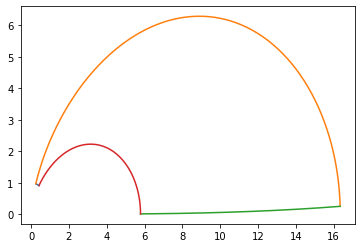

In [7]:
x = grid[:,:,0]*np.sin(grid[:,:,1])
z = grid[:,:,0]*np.cos(grid[:,:,1])

plt.plot( x[0,:], z[0,:] )
plt.plot( x[:,0], z[:,0] )
plt.plot( x[127,:], z[127,:] )
plt.plot( x[:,2560], z[:,2560] )

In [8]:
print( (x**2+z**2).min(), (x[0,:]**2+z[0,:]**2).max() )

0.9999999 1.0000001


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  after removing the cwd from sys.path.


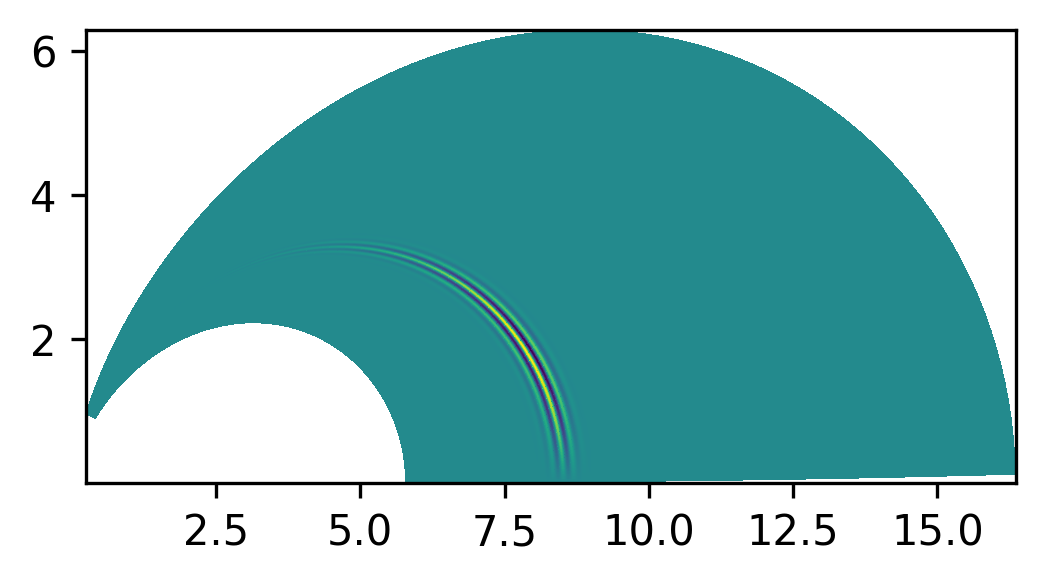

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  # Remove the CWD from sys.path while we load stuff.


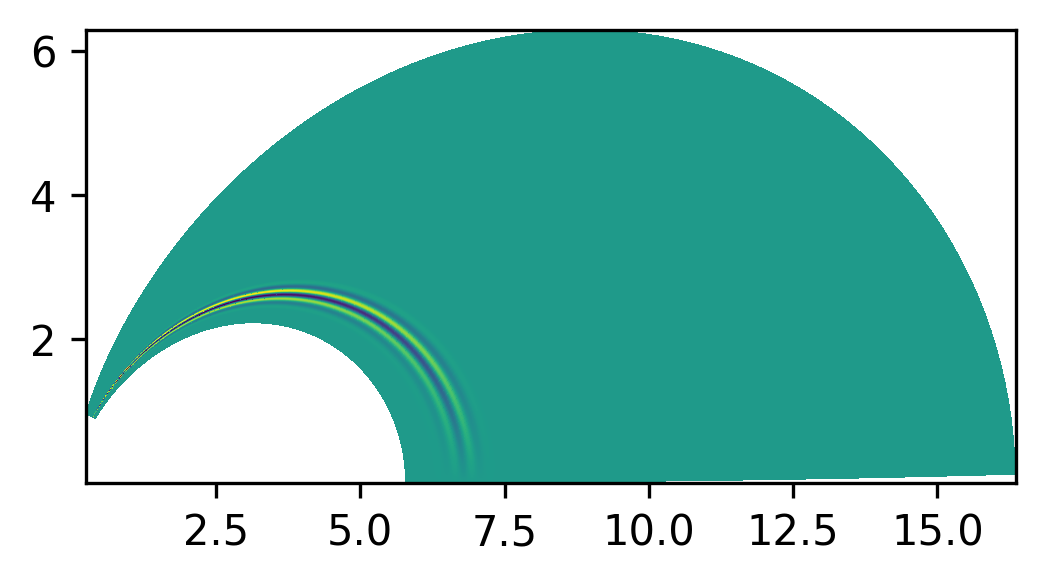

In [10]:
t, omg = fourier_func(nprocz_mpi, 0)
# t, omg, cpr, phi, psi = fourier_func(nprocz_mpi-1, 0)
print(omg.shape)

dpi = 300
t, omg = fourier_func(nprocz_mpi, 30)
fig, ax= plt.subplots(figsize=(4,2), dpi=dpi)
ax.pcolormesh(x,z,np.real(omg[:,:])/grid[:,:,4] , shading="nearest")
plt.show()
# ax.set_xlim(0.25,1)
# ax.set_ylim(0.75,2.25)
t, omg = fourier_func(nprocz_mpi, 1320)
fig, ax= plt.subplots(figsize=(4,2), dpi=dpi)
ax.pcolormesh(x,z,np.real(omg[:,:])*grid[:,:,4]  , shading="nearest")
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


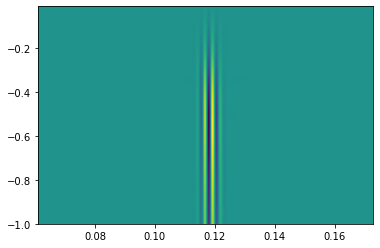

In [11]:
t, omg = fourier_func(nprocz_mpi, 80)
plt.pcolormesh(grid[:,:,2], grid[:,:,3], np.real(omg[:,:])*grid[:,:,4]  )

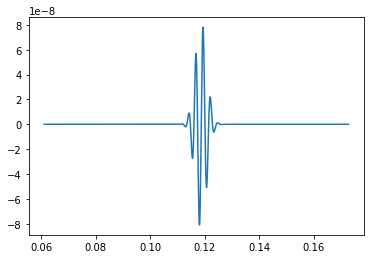

In [12]:
plt.plot( grid[0,:,2], np.real(omg[0,:])  )

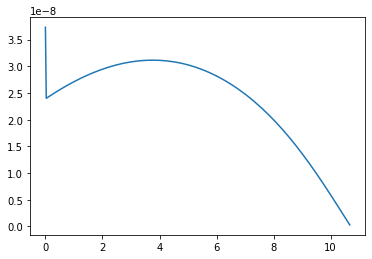

In [13]:
t, omg = fourier_func(nprocz_mpi, 0)
ix = 1300
dz = 1/128
xi3 = np.zeros(128, dtype="float32")
for i in range(1,128):
    xi3[i] = xi3[i-1]+dz*grid[i,ix,5]
# plt.plot( grid[:,0,3], np.real(omg[:,0,1280])*grid[:,0,4]  )
plt.plot( xi3, np.real(omg[:,ix])*grid[:,ix,4]  )

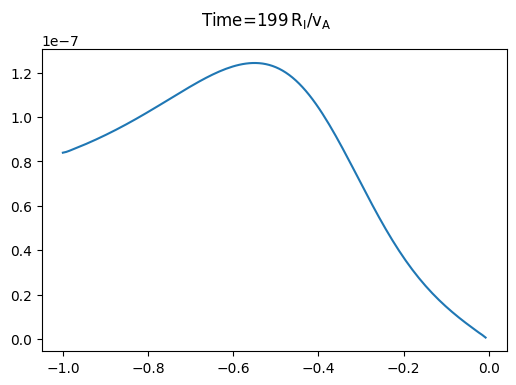

In [14]:
# import ffmpeg
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
plt.rcParams["animation.embed_limit"] = 50.0   # アニメーションサイズ(MB)
##  fig setting  ##
dpi = 100
fig, ax= plt.subplots(figsize=(6,4), dpi=dpi)
##  fig setting END  ##
# it = 0

ix = 1400

t, omg = fourier_func(nprocz_mpi, 0)
plt.plot( grid[:,0,3], np.real(omg[:,ix])*grid[:,ix,4]  )
title = fig.suptitle("Time=$%.0f\,\mathrm{R_I/v_A}$"%t )
# my_line, = ax.plot([], [])

def update_line(it):
    ax.cla() # ax をクリア
    t, omg = fourier_func(nprocz_mpi, it)
    title.set_text("Time=$%.0f\,\mathrm{R_I/v_A}$"%t )
#     my_line, = ax.plot( grid[:,0,3], np.real(omg[:,0,1280])*grid[:,0,4])
    ax.plot( grid[:,0,3], np.real(omg[:,ix])*grid[:,ix,4]  )
    
ani = FuncAnimation(fig, update_line, frames=range(0,200,1), interval=100)
# ani.save("./ion_dns_intvl50.mp4", writer="ffmpeg")
#ani.save("./ion_omg_wo_ebdrift_intvl50.mp4", writer="ffmpeg")
HTML(ani.to_jshtml())

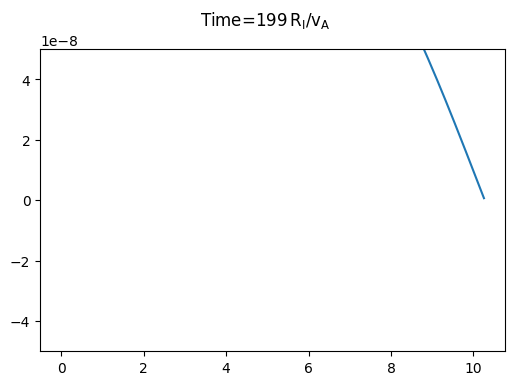

In [15]:
t, omg = fourier_func(nprocz_mpi, 0)
ixi1 = 1400
dz = 1/128
xi3 = np.zeros(128, dtype="float32")
for i in range(1,128):
    xi3[i] = xi3[i-1]+dz*grid[i,ixi1,5]
    
dpi = 100
fig, ax= plt.subplots(figsize=(6,4), dpi=dpi)
##  fig setting END  ##
# it = 0

amp = 0.5*10**(-7)
t, omg = fourier_func(nprocz_mpi, 0)
ax.plot( xi3, np.real(omg[:,ixi1])*grid[:,ixi1,4]  )
title = fig.suptitle("Time=$%.0f\,\mathrm{R_I/v_A}$"%t )
ax.set_ylim( -amp, amp )
# my_line, = ax.plot([], [])

def update_line(it):
    ax.cla() # ax をクリア
    t, omg = fourier_func(nprocz_mpi, it)
    title.set_text("Time=$%.0f\,\mathrm{R_I/v_A}$"%t )
    ax.set_ylim( -amp, amp)
#     my_line, = ax.plot( grid[:,0,3], np.real(omg[:,0,1280])*grid[:,0,4])
    ax.plot( xi3, np.real(omg[:,ixi1])*grid[:,ixi1,4]  )
    
ani = FuncAnimation(fig, update_line, frames=range(0,200,1), interval=100)
# ani.save("./ion_dns_intvl50.mp4", writer="ffmpeg")
#ani.save("./ion_omg_wo_ebdrift_intvl50.mp4", writer="ffmpeg")
HTML(ani.to_jshtml())